In [1]:
import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from edward.models import Normal, Empirical, Gamma
import xgboost as xg
from sklearn.model_selection import train_test_split 

/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: 

In [2]:
def build_toy_dataset(N, w, noise_std=0.1):
  D = len(w)
  x = np.random.randn(N, D)
  y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
  return x, y

N = 40  # number of data points
D = 2  # number of features

w_true = np.random.randn(D)
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

In [3]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

In [4]:
X_xgb, y_xgb = build_toy_dataset(N, w_true)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, 
                      test_size = 0.1, random_state = 123) 

In [5]:
# Fitting the model 
xgb_r.fit(X_train_xgb, y_train_xgb) 

[06:28:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [6]:
# Predict the model 
pred = xgb_r.predict(X_test_xgb)
print(pred)

[-0.6132667  -0.6132667   1.1964705   0.46343082]


In [7]:
#X = tf.placeholder(tf.float32, [N, D])
X = tf.constant(X_train)
print(type(X))
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=2*tf.ones(1))
#y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))
with tf.Session() as sess:
    X_val = X.eval(session = sess)
y = Normal(loc=xgb_r.predict(X_val)*b, scale=tf.ones(N))

<class 'tensorflow.python.framework.ops.Tensor'>


In [8]:
qw = Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

In [9]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

/home/jovyan/.local/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 44.393


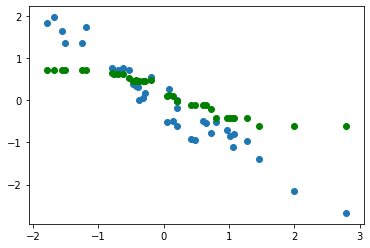

In [10]:
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_train[:,0], xgb_r.predict(X_train), color = 'g')

In [19]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  data = plt.scatter(X_data[:, 0], y_data)
  xgb_pred = plt.scatter(X_train[:,0], xgb_r.predict(X_train), color = 'b')
  #inputs = np.linspace(-8, 8, num=400)
  inputs = X_train
#   for ns in range(n_samples):
#     #output = inputs * w_samples[ns] + b_samples[ns]
#     output = xgb_r.predict(inputs)*b_samples[ns]
#     plt.plot(inputs[:,0], output)
  output_mean = xgb_r.predict(inputs) * b_samples.mean()
  output_p10 = xgb_r.predict(inputs) * np.percentile(b_samples,0.1)
  output_p90 = xgb_r.predict(inputs) * np.percentile(b_samples, 0.9)
  mean = plt.scatter(X_train[:,0], output_mean, color = 'r')
  p10 = plt.scatter(X_train[:,0], output_p10, color = 'y')
  p90 = plt.scatter(X_train[:,0], output_p90, color = 'g')
  plt.legend((data, xgb_pred, mean, p10, p90),
           ('data', 'xgb','Bayes mean', 'Bayes P10', 'Bayes P90'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

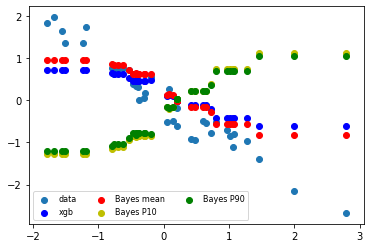

In [20]:
# Visualize samples from the prior.
visualise(X_train, y_train, w, b)

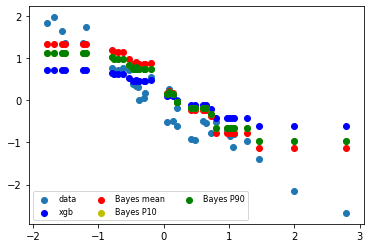

In [21]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw, qb)